In [86]:
import os.path
import math
%matplotlib inline
%matplotlib qt

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.ticker import NullLocator
import numpy as np

##  This notebook attempts to analyze the effects of sigma and msigma for the DynamicERI cholesky decomposition algorithm

Threshold $\tau = 10^{-4}$ 

In [87]:
root = '/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/'
system = 'H1000'
basis = 'sto3g'
integral_engine = 'libint'
contraction_type = 's'
taus = ['1e-8', '1e-6', '1e-4'] 
sigmas = ['1','5e-1','1e-1','5e-2','1e-2','5e-3','1e-3','5e-4','1e-4','5e-5','1e-5']
maxquals = [20000,5000,2000,1500,1250,1000,750,500,250,100,50,20,1]

In [88]:
for tau in taus:
    for sigma in sigmas:
        for maxqual in maxquals:

            fname = root + system
            
            fname += '_%s_%s%s' % (basis,integral_engine,contraction_type)

            fname += '_t%s_s%s_m%d' % (tau,sigma,maxqual)

            fname += '.out'

            print(fname)

/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m20000.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m5000.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m2000.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m1500.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m1250.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m1000.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m750.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m500.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t1e-8_s1_m250.out
/Users/aodongliu/LiGroup/cholesky/study_param/H1000/libint_seg/H1000_sto3g_libints_t

In [89]:
def parseOutput(fname):

    if not os.path.exists(fname):
        return None
    f = open(fname)

    # dynamicERIProgress is a dictionary object that holds the step-by-step data obtained during the CD progress
    dynamicERIProgress = {}
    # dynamicERITotal is a dictionary object that holds cumulataive data
    dynamicERITotal = {}


    # Initialize the following keys for dynamicERIProgress to hold lists:

    # Pivot candidates. This corresponds to P in the paper
    dynamicERIProgress['D_size']= []

    # The current batch selected based on sigma and msigma. This corresponds to Q in the paper
    dynamicERIProgress['lenQ']= []

    # The number of computed ERI vectors (of length D) stored in memory. This corresponds to Epsilon in the paper
    dynamicERIProgress['ERI_vec']= []

    # The time used for shrinking of the current batch. This corresponds to line 39
    dynamicERIProgress['shrink_time']= []

    # Time used to do transpose for the current batch
    dynamicERIProgress['ERI_trans']= []

    # The number of ERIs calculated for current batch. This corresponds to line 20
    dynamicERIProgress['ERI_count']= []

    # Time used to calculate ERI for current batch, all threads added together. This corresponds to line 20
    dynamicERIProgress['ERI_duration_all']= []

    # Time used to calculate ERI for current batch, wall clock. This corresponds to line 20
    dynamicERIProgress['RI_duration_wall']= []

    # Time used to copy for the current batch. This corresponds to line 22
    dynamicERIProgress['ERI_copy']= []

    # Time used to do CD for the current batch. This corresponds to line 22
    dynamicERIProgress['CDalgMM']= []

    # Time used to do CD for the current batch in the innerloop. This corresponds to line 30
    dynamicERIProgress['innerloop_CDalgMM']= []

    # Time used for the current batch in the innerloop. This corresponds to line 27-33
    dynamicERIProgress['innerloop_time']= []




    for line in f:

        # Add cumulative data key-value pairs into dynamicERITotal
        if 'Cholesky-RI-Pivots-ERI count' in line:
            dynamicERITotal['N1ERI'] = int(line.split('= ')[-1])

        if 'Cholesky-RI-Pivots-ERI duration' in line:
            dynamicERITotal['T1ERI_AllThreads'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-ERIvec duration     =' in line:
            dynamicERITotal['T1ERI_WC'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-ERIcopy duration    =' in line:
            dynamicERITotal['ERIcopy'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-ERItrans duration   =' in line:
            dynamicERITotal['ERItrans'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-CDalgMM duration    =' in line:
            dynamicERITotal['CDalgMM'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-CDalgMV duration    =' in line:
            dynamicERITotal['CDalgMV'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-Shrink count        =' in line:
            dynamicERITotal['NShrink'] = int(line.split('= ')[-1])

        if 'Cholesky-RI-Shrink duration     =' in line:
            dynamicERITotal['TShrink'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-misc duration       =' in line:
            dynamicERITotal['misc'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-Dynamic-ERI-Pivots duration =' in line:
            dynamicERITotal['T1'] = float(line.split('= ')[-1].split()[0])

        if 'Cholesky-RI-auxiliary dimension =' in line:
            dynamicERITotal['NPivots'] = int(line.split('= ')[-1])



        # Append values of each step into corresponding list in dynamicERIProgress
        if 'D size =' in line:
            dynamicERIProgress['D_size'].append(float(line.split('= ')[-1]))

        if 'lenQ:' in line:
            dynamicERIProgress['lenQ'].append(int(line.split(':')[-1]))

        if 'ERI size =' in line:
            dynamicERIProgress['ERI_vec'].append(int(line.split('= ')[-1]))

        if 'Current Shrink =' in line:
            dynamicERIProgress['shrink_time'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current ERItrans =' in line:
            dynamicERIProgress['ERI_trans'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current ERI count    =' in line:
            dynamicERIProgress['ERI_count'].append(int(line.split('= ')[-1]))

        if 'Current ERI duration =' in line:
            dynamicERIProgress['ERI_duration_all'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current ERIvec =' in line:
            dynamicERIProgress['RI_duration_wall'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current ERIcopy =' in line:
            dynamicERIProgress['ERI_copy'].append(float(line.split('= ')[-1].split()[0]))

        if 'Current CDalgMM =' in line:
            dynamicERIProgress['CDalgMM'].append(float(line.split('= ')[-1].split()[0]))

        if 'InnerLoop CDalgMV  =' in line:
            dynamicERIProgress['innerloop_CDalgMM'].append(float(line.split('= ')[-1].split()[0]))

        if 'InnerLoop duration =' in line:
            dynamicERIProgress['innerloop_time'].append(float(line.split('= ')[-1].split()[0]))


    f.close()
    return dynamicERIProgress, dynamicERITotal


In [146]:
progress,total=parseOutput('/Users/aodongliu/LiGroup/cholesky/study_param/H2O50/libint_seg/631gdfc/H2O50_631gdfc_libints_t1e-6_s1e-1_m1000.out')

In [147]:
progress.keys()

dict_keys(['D_size', 'lenQ', 'ERI_vec', 'shrink_time', 'ERI_trans', 'ERI_count', 'ERI_duration_all', 'RI_duration_wall', 'ERI_copy', 'CDalgMM', 'innerloop_CDalgMM', 'innerloop_time'])

In [148]:
for key in progress.keys():
    print(key, len(progress[key]), type(progress[key][0]))

D_size 16 <class 'float'>
lenQ 16 <class 'int'>
ERI_vec 16 <class 'int'>
shrink_time 15 <class 'float'>
ERI_trans 15 <class 'float'>
ERI_count 16 <class 'int'>
ERI_duration_all 16 <class 'float'>
RI_duration_wall 16 <class 'float'>
ERI_copy 16 <class 'float'>
CDalgMM 16 <class 'float'>
innerloop_CDalgMM 16 <class 'float'>
innerloop_time 16 <class 'float'>


In [149]:
total

{'N1ERI': 9656064,
 'T1ERI_AllThreads': 15.454,
 'T1ERI_WC': 0.86841,
 'ERIcopy': 0.075472,
 'ERItrans': 0.01619,
 'CDalgMM': 0.83087,
 'CDalgMV': 0.61357,
 'NShrink': 15,
 'TShrink': 0.87632,
 'misc': 0.82596,
 'T1': 4.1068,
 'NPivots': 6924}

In [150]:
x = np.arange(1,total['NShrink']+1,1)

x1 = np.arange(1,total['NShrink']+2,1)


In [151]:
plt.plot(x1,progress['ERI_vec'])

In [152]:
progress['ERI_vec']

[1950,
 3892,
 4022,
 3852,
 3440,
 2978,
 2246,
 2626,
 2202,
 2085,
 2113,
 2011,
 2228,
 1831,
 1457,
 433]

In [ ]:
def parseDynamicERI(sys, tau):
    sfsteps = []
    sfmems = []
    sfpivotMems = []
    sfpivots = 0
    sfDsize = 0
    sflenQ = 0
    f = open(root + dirs[sys][0] + dirs[sys][2] % tau)
    for line in f:
        if 'D size =' in line:
            sfDsize = int(line.split('= ')[-1])
        if 'lenQ:' in line:
            sflenQ = int(line.split(': ')[-1])
            sfsteps.append(sfpivots)
            sfmems.append(8*sfDsize*(sflenQ+sfpivots))
            sfpivotMems.append(8*sfDsize*sfpivots)
        if 'pivot Size' in line:
            sfpivots = int(line.split('= ')[-1])
            sfsteps.append(sfpivots)
            sfmems.append(sfmems[-1])
            sfpivotMems.append(8*sfDsize*sfpivots)
    f.close()
    return sfsteps, sfmems, sfpivotMems

In [1]:
dirs = {'H1000':('H1000/', 'H1000_dynamic_t%s_D_n20.out', 'H1000_spanfactor_t%s_D_n28_s1e-2_Mpq_Ssig.out'),
        'C60sto':('C60sto3g/', 'C60_dynamic_t%s_D_n1.out', 'C60_spanfactor_t%s_D_n28_s1e-2_Mpq_Ssig.out'),
        'C60vdz':('C60ccpvdz/', 'C60_dz_dynamic_t%s_D_n20.out', 'C60_dz_spanfactor_t%s_D_n28_s1e-2_Mpq_Ssig.out'),
        'W50'   :('Water50_631Gd/', 'W50_631Gd_dynamic_t%s_D_n28.out', 'W50_631Gd_spanfactor_t%s_D_n28_s1e-2_Mpq_Ssig.out'),
        'Au14'  :('Au14/', 'Au14_jorge_tzp_dkh_dynamic_t%s_D_n28.out', 'Au14_jorge_tzp_dkh_spanfactor_t%s_D_n28_s1e-2_Mpq_Ssig.out')}
nBases = {'H1000': 1000, 'C60sto': 300, 'C60vdz': 840, 'W50':900, 'Au14':1148 }
taus = ['1e-4', '1e-6', '1e-8']
# taus_Au = ['1e-3', '1e-4', '1e-5', '1e-6']
syss = ['H1000', 'C60vdz','W50','Au14']#'C60sto'
root = '/Users/zty/Documents/LiGroup/workspace/RI/'

In [2]:
sys = 'W50'
tau = '1e-6'

In [4]:
def curveIntegral(x,y):
    sum = 0
    for i in range(len(x)-1):
        sum += (x[i+1] - x[i]) * (y[i] + y[i+1]) // 2
    return sum

In [5]:
def plotMem(steps, mems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems):
    fig, ax = plt.subplots()
    #     fig, ax = plt.subplots()
    ax.spines['right'].set_visible(False)     # remove the right boundary of the plot
    ax.spines['top'].set_visible(False)       # remove the top boundary of the plot
    #     ax.spines['top'].set_position('zero')
    plt.tick_params(
        direction='out',
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,       # ticks along the bottom edge are on
        top=False,         # ticks along the top edge are off
        width=0.5,
        length=2)
    plt.tick_params(
        direction='out',
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,         # ticks along the left edge are on
        right=False,       # ticks along the left edge are off
        width=0.5,
        length=2)

    plt.plot(steps, mems)
    plt.plot(allocBlockSteps, allocBlockSizes)
    plt.plot(sfsteps, sfmems)

    plt.tight_layout()
    plt.savefig('tmp.pdf')

In [6]:
def plotCost(nBasis, steps, pivotMems, sfsteps, sfpivotMems):
    fig, ax = plt.subplots()
    #     fig, ax = plt.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #     ax.spines['top'].set_position('zero')
    plt.tick_params(
        direction='out',
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,       # ticks along the bottom edge are on
        top=False,         # ticks along the top edge are off
        width=0.5,
        length=2)
    plt.tick_params(
        direction='out',
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,         # ticks along the left edge are on
        right=False,       # ticks along the left edge are off
        width=0.5,
        length=2)

    dyCost = [x // 8 for x in pivotMems]
    sfCost = [x // 8 for x in sfpivotMems]
    plt.plot(steps, dyCost)
    plt.plot(sfsteps, sfCost)
    
    tradX = [0, steps[-1]]
    tradY = [0, nBasis**2 * steps[-1]]
    plt.plot(tradX, tradY)
    
    plt.ylim([0, 1.05* max(max(dyCost),max(sfCost))])

    plt.tight_layout()
    plt.savefig('tmp.pdf')

In [7]:
def plotNumber(steps, nMallocs, nVecs, nCands):
    fig, ax = plt.subplots()
    #     fig, ax = plt.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #     ax.spines['top'].set_position('zero')
    plt.tick_params(
        direction='out',
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,       # ticks along the bottom edge are on
        top=False,         # ticks along the top edge are off
        width=0.5,
        length=2)
    plt.tick_params(
        direction='out',
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,         # ticks along the left edge are on
        right=False,       # ticks along the left edge are off
        width=0.5,
        length=2)

    plt.plot(steps, nMallocs)
    plt.plot(steps, nVecs)
    plt.plot(steps, nCands)

    plt.tight_layout()
    plt.savefig('tmp.pdf')

In [8]:
def plotSubs(steps, mems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, nMallocs, nVecs, nCands, pivotMems, sfpivotMems, nBasis):
    fig, ax = plt.subplots(3,1, sharex=True)
    for i in range(3):
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
    #     ax.spines['top'].set_position('zero')
    plt.tick_params(
        direction='out',
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,       # ticks along the bottom edge are on
        top=False,         # ticks along the top edge are off
        width=0.5,
        length=2)
    plt.tick_params(
        direction='out',
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,         # ticks along the left edge are on
        right=False,       # ticks along the left edge are off
        width=0.5,
        length=2)
    
    ax[0].plot(steps, mems)
    ax[0].plot(allocBlockSteps[1:], allocBlockSizes[1:])
    ax[0].plot(sfsteps, sfmems)
    
    ax[0].set_ylim([0, 1.05* max(max(sfmems),max(allocBlockSizes))])

    dyCost = [x // 8 for x in pivotMems]
    sfCost = [x // 8 for x in sfpivotMems]
    ax[1].plot(steps, dyCost)
    ax[1].plot(sfsteps, sfCost)
    
    tradX = [0, steps[-1]]
    tradY = [0, nBasis**2 * steps[-1]]
    ax[1].plot(tradX, tradY)
    
    ax[1].set_ylim([0, 1.05* max(max(dyCost),max(sfCost))])
    
    ax[2].plot(steps, nMallocs)
    ax[2].plot(tradX, tradX)
    ax[2].plot(steps, nCands)
    
    ax[2].set_ylim([0, nCands[0]])

    plt.tight_layout()
    plt.savefig('tmp.pdf')

In [9]:
def parseDynamic(sys, tau):
    initialCandFlag = 'Initial candidate size ='
    mallocBlockFlag = 'Malloc a block of size'
    selectionFlag = 'Selected: ('
    newLengthFlag = 'New vector length ='
    mallocFlag = 'Malloc called'
    freeFlag = 'Free called'
    shrinkFlag = 'Shrink called'

    steps = []
    mems = []
    pivotMems = []
    nMallocs = []
    nVecs = []
    nLenVecs = []
    nCands = []
    allocBlockSteps = []
    allocBlockSizes = []
    pivots = 0
    Dsize = 0
    allocBlock = 0
    allocIndiv = 0
    curFree = 0
    nMalloc = 0
    
    curVecLen = -1
    
    f = open(root + dirs[sys][0] + dirs[sys][1] % tau)
    keyLines = []
    for line in f:
        if initialCandFlag in line:
            Dsize = int(line.split('= ')[-1])
            curVecLen = Dsize
        if newLengthFlag in line:
            Dsize = int(line.split('= ')[-1])
        if shrinkFlag in line:
            curVecLen = Dsize
        if selectionFlag in line:
            steps.append(pivots)
            nCands.append(Dsize)
            nLenVecs.append(curVecLen)
            nVecs.append(allocIndiv)
            nMallocs.append(nMalloc)
            mems.append(Dsize * allocIndiv * 8)
            pivotMems.append(Dsize * pivots * 8)
            pivots += 1
            allocIndiv -= curFree
            curFree = 0
        if mallocBlockFlag in line:
            allocBlockSteps.append(pivots)
            allocBlockSizes.append(8 * allocBlock)
            allocBlock += int(line.split(' ')[-1])
            allocBlockSteps.append(pivots)
            allocBlockSizes.append(8 * allocBlock)
        if mallocFlag in line:
            allocIndiv += 1
            nMalloc += 1
        if freeFlag in line:
            curFree += 1
    allocBlockSteps.append(pivots)
    allocBlockSizes.append(8 * allocBlock)
    steps.append(pivots)
    nCands.append(0)
    nLenVecs.append(0)
    nMallocs.append(nMalloc)
    nVecs.append(pivots)
    mems.append(0)
    pivotMems.append(0)
    f.close()
    
    return steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes

In [10]:
def parseSpanFactor(sys, tau):
    sfsteps = []
    sfmems = []
    sfpivotMems = []
    sfpivots = 0
    sfDsize = 0
    sflenQ = 0
    f = open(root + dirs[sys][0] + dirs[sys][2] % tau)
    for line in f:
        if 'D size =' in line:
            sfDsize = int(line.split('= ')[-1])
        if 'lenQ:' in line:
            sflenQ = int(line.split(': ')[-1])
            sfsteps.append(sfpivots)
            sfmems.append(8*sfDsize*(sflenQ+sfpivots))
            sfpivotMems.append(8*sfDsize*sfpivots)
        if 'pivot Size' in line:
            sfpivots = int(line.split('= ')[-1])
            sfsteps.append(sfpivots)
            sfmems.append(sfmems[-1])
            sfpivotMems.append(8*sfDsize*sfpivots)
    f.close()
    return sfsteps, sfmems, sfpivotMems

In [11]:
def fillActualAlloc(steps, allocBlockSteps, allocBlockSizes):
    detailAlloc = []
    looseStep = 0
    for x in steps:
        if looseStep + 1 < len(allocBlockSteps) and x > allocBlockSteps[looseStep + 1]:
            looseStep += 1
        detailAlloc.append(allocBlockSizes[looseStep])
    return detailAlloc

In [12]:
def fillCost(steps, sfsteps, sfCost):
    detailSf = []
    looseStep = 0
    for x in steps:
        while looseStep + 1 < len(sfsteps) and x > sfsteps[looseStep + 1]:
            looseStep += 1
        if looseStep + 1 == len(sfsteps):
            detailSf.append(x * sfCost[looseStep] / sfsteps[looseStep])
        else:
            detailSf.append(x * sfCost[looseStep + 1] / sfsteps[looseStep + 1])
    return detailSf

In [13]:
def plotDetail(ax, costScale, numScale, memScale, steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, sfpivotMems, plotLenVec = True, plotNvec = True):
    for i in range(3):
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
    #     ax.spines['top'].set_position('zero')
        ax[i].tick_params(
            direction='out',
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=True,       # ticks along the bottom edge are on
            top=False,         # ticks along the top edge are off
            width=0.5,
            length=2)
        ax[i].tick_params(
            direction='out',
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=True,         # ticks along the left edge are on
            right=False,       # ticks along the left edge are off
            width=0.5,
            length=2)

    tradX = [0, steps[-1]]
    tradY = [0, nBases[sys]*(nBases[sys]+1)/2 * steps[-1] * costScale]
    ax[0].plot(tradX, tradY, color = colors[3])

    dyCost = []
    if plotLenVec:
        dyCost = [i * nLenVecs[i] * costScale for i in range(len(steps))]
    else:
        dyCost = [x * costScale / 8 for x in pivotMems]
    sfCost = [x * costScale / 8 for x in sfpivotMems]
    ax[0].plot(sfsteps, sfCost, color = colors[4])
    ax[0].plot(steps, dyCost, color = colors[0])

    actualSf = fillCost(steps, sfsteps, sfCost)
    ax[0].fill_between(sfsteps, sfCost, color = colors[4], alpha = 0.5, lw = 0)
    ax[0].fill_between(steps, dyCost, color = 'white', alpha = 1.0, lw = 0)
    ax[0].fill_between(steps, dyCost, color = colors[0], alpha = 0.5, lw = 0)
    
    ax[0].set_ylim([0, 1.05 * max(max(dyCost),max(sfCost))])


    if plotNvec:
        ax[1].plot(steps, [x * numScale for x in nVecs], color = colors[1])
    ax[1].plot(tradX, [x * numScale for x in tradX], color = colors[0])
    if plotNvec:
        ax[1].plot(steps, [x * numScale for x in nMallocs], color = colors[2])
    ax[1].plot(steps, [x * numScale for x in nCands], color = 'g')
    ax[1].fill_between(tradX, [x * numScale for x in tradX], color = colors[0], alpha = 0.5, lw = 0)
    if plotNvec:
        ax[1].fill_between(steps, [x * numScale for x in steps], [x * numScale for x in nMallocs], color = colors[2], alpha = 0.5, lw = 0)


    ax[2].plot(allocBlockSteps[1:], [x * memScale for x in allocBlockSizes[1:]], color = colors[2])
    ax[2].plot(steps, [x * memScale for x in mems], color = colors[0])
    ax[2].plot(sfsteps, [x * memScale for x in sfmems], color = colors[4])

    actualAlloc = fillActualAlloc(steps, allocBlockSteps[1:], [x * memScale for x in allocBlockSizes[1:]])
    ax[2].fill_between(steps, [x * memScale for x in mems], actualAlloc, color = colors[2], alpha = 0.5, lw = 0)
    ax[2].fill_between(steps, [x * memScale for x in mems], color = colors[0], alpha = 0.5, lw = 0)

    ax[2].set_xlabel('Number of selected Cholesky basis')

<IPython.core.display.Javascript object>


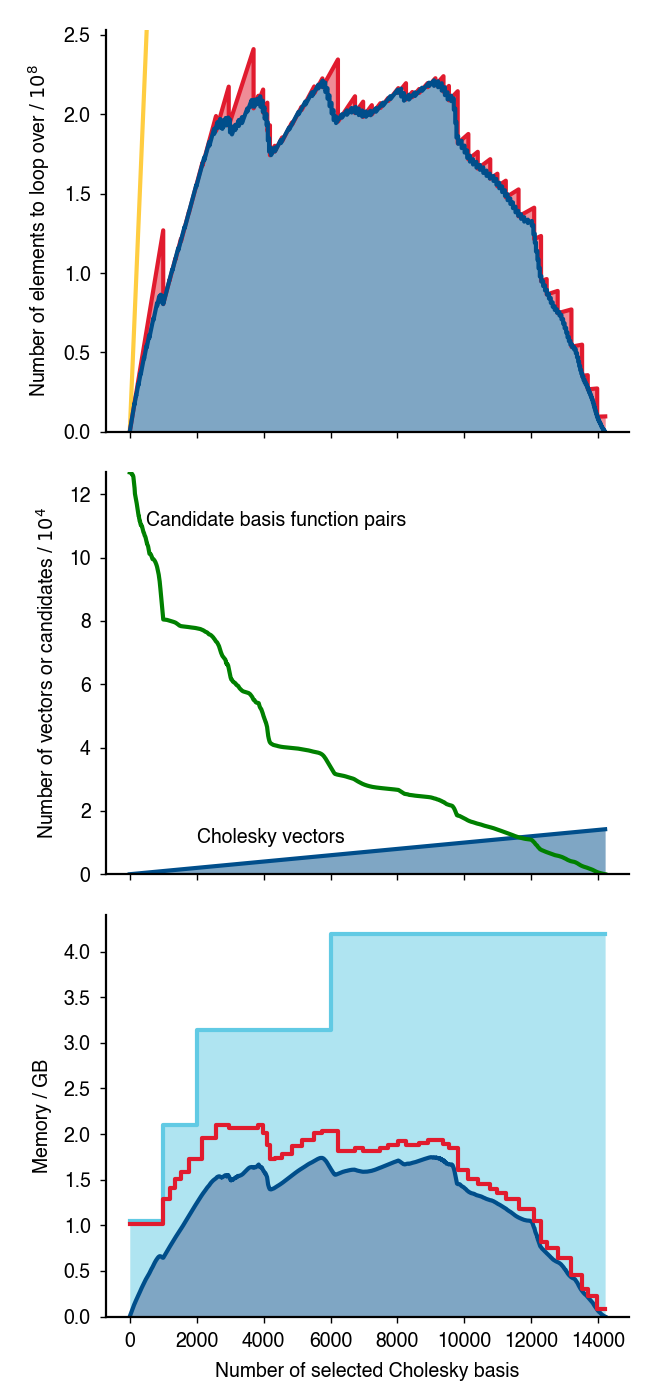

In [31]:
sys = 'H1000'
tau = '1e-8'
steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes = parseDynamic(sys, tau)
sfsteps, sfmems, sfpivotMems = parseSpanFactor(sys, tau)
fig, ax = plt.subplots(3,1, sharex=True)

plotDetail(ax, 1e-8, 1e-4, 1e-9, steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, sfpivotMems, plotNvec = False, plotLenVec= True)

ax[0].set_ylim([0, 1.05 / 8e8 * max(max(pivotMems),max(sfpivotMems))])
# ax[0].set_yticks([0, 1, 2, 3, 4])
ax[0].set_ylabel('Number of elements to loop over / $10^8$')
# ax[0].text(1700, 14, 'Traditional')
# ax[0].text(4800, 10.5, 'Span-Factor')
# ax[0].text(900, 3.7, 'Traditional')
# ax[0].text(5500, 3.5, 'Span-Factor')
# ax[0].text(4800, 1.0, 'Dynamic')

ax[1].set_ylim([0, nCands[0] * 1e-4])
# ax[1].set_yticks([0, 5, 10, 15, 20, 25])
ax[1].set_ylabel('Number of vectors or candidates / $10^4$')
ax[1].text(500, 11, 'Candidate basis function pairs')
# ax[1].annotate('Evaluated ERI vectors', xy = (2000,3.5), xytext = (0, 5), arrowprops={'arrowstyle':'->'})
# ax[1].annotate('Vectors in memory', xy = (3770,4), xytext = (2700, 8), arrowprops={'arrowstyle':'->'})
# ax[1].text(1000, 3, 'Evaluated ERI vectors')
ax[1].text(2000, 1, 'Cholesky vectors')

ax[2].set_ylim([0, 1.05e-9 * max(max(sfmems),max(allocBlockSizes))])
# ax[2].set_yticks([0,5,10,15])
ax[2].set_ylabel('Memory / GB')
# ax[2].text(5000, 10.7, 'Allocated in span-factor algorithm')
# ax[2].text(0, 4.5, 'Allocated in dynamic algorithm')
# ax[2].text(2000, 0.7, 'Necessary in dynamic algorithm')

plt.tight_layout()
plt.savefig('H1000.pdf')

In [15]:
# sys = 'C60sto'
# tau = '1e-8'
# steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes = parseDynamic(sys, tau)
# sfsteps, sfmems, sfpivotMems = parseSpanFactor(sys, tau)
# fig, ax = plt.subplots(3,1, sharex=True)

# plotDetail(ax, 1e-7, 1e-3, 1e-6, steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, sfpivotMems)

# ax[0].set_ylim([0, 1.05 / 8e7 * max(max(pivotMems),max(sfpivotMems))])
# # ax[0].set_yticks([0, 0.5, 1, 1.5, 2])
# ax[0].set_ylabel('Number of elements to loop over / $10^7$')
# ax[0].text(400, 3.0, 'Traditional')
# ax[0].text(2100, 2.5, 'Span-Factor')
# ax[0].text(1200, 1.0, 'Dynamic')

# ax[1].set_ylim([0, nCands[0] * 1e-3])
# # ax[1].set_yticks([0, 5, 10, 15, 20, 25])
# ax[1].set_ylabel('Number of vectors or candidates / $10^3$')
# ax[1].text(500, 13, 'Candidate basis function pairs')
# ax[1].annotate('Evaluated ERI vectors', xy = (2000,3.5), xytext = (0, 5), arrowprops={'arrowstyle':'->'})
# ax[1].annotate('Vectors in memory', xy = (3770,4), xytext = (2700, 8), arrowprops={'arrowstyle':'->'})
# # ax[1].text(1000, 3, 'Evaluated ERI vectors')
# ax[1].text(2000, 1, 'Cholesky vectors')

# ax[2].set_ylim([0, 1.2e-6 * max(max(sfmems),max(allocBlockSizes))])
# # ax[2].set_yticks([0,5,10,15])
# ax[2].set_ylabel('Memory / MB')
# # ax[2].text(0, 310, 'Allocated in span factor algorithm')
# ax[2].annotate('Allocated in span-factor algorithm', xy = (1000,270), xytext = (0, 310), arrowprops={'arrowstyle':'->'})
# ax[2].annotate('Allocated in dynamic algorithm', xy = (3000,310), xytext = (1700, 350), arrowprops={'arrowstyle':'->'})
# # ax[2].text(0, 8.5, 'Allocated in dynamic algorithm')
# ax[2].text(800, 50, 'Necessary in dynamic algorithm')

# plt.tight_layout()
# plt.savefig('C60sto.pdf')

<IPython.core.display.Javascript object>


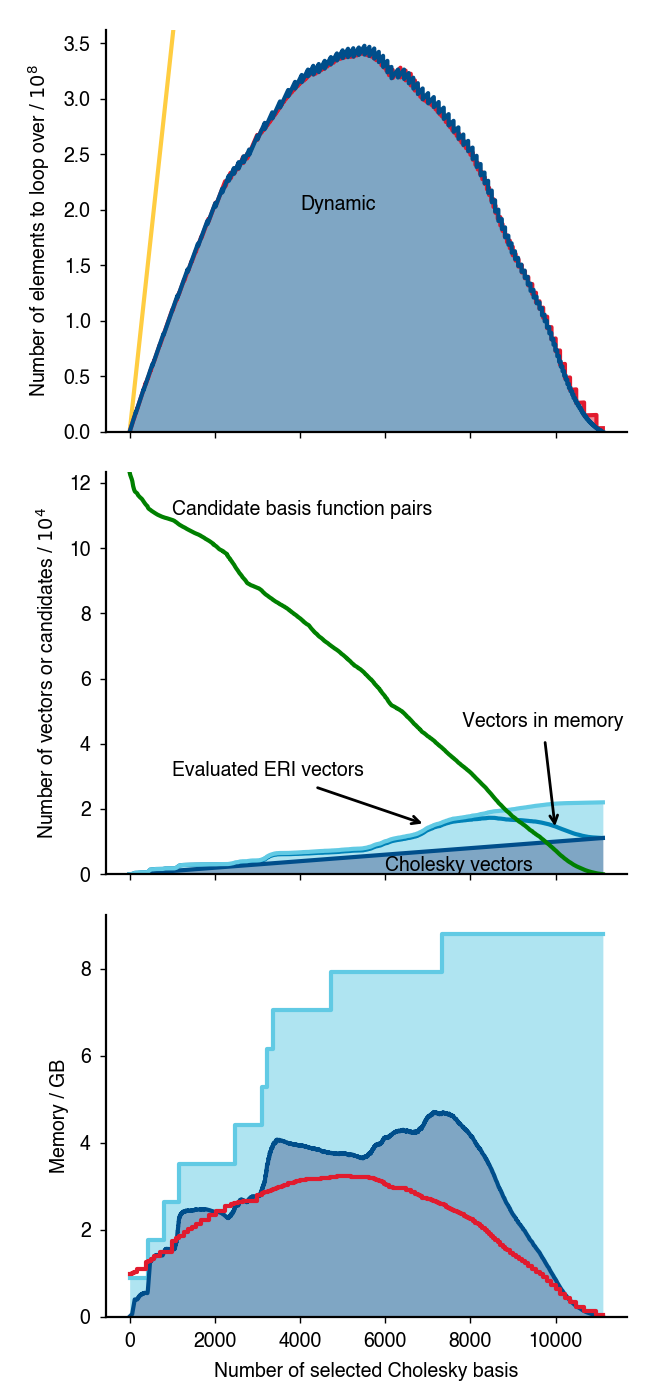

In [23]:
sys = 'C60vdz'
tau = '1e-8'
steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes = parseDynamic(sys, tau)
sfsteps, sfmems, sfpivotMems = parseSpanFactor(sys, tau)
fig, ax = plt.subplots(3,1, sharex=True)

plotDetail(ax, 1e-8, 1e-4, 1e-9, steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, sfpivotMems)


ax[0].set_ylim([0, 1.05 / 8e8 * max(max(pivotMems),max(sfpivotMems))])
ax[0].set_ylabel('Number of elements to loop over / $10^8$')
# ax[0].text(2000, 11, 'Traditional')
# ax[0].text(4000, 8.5, 'Span-Factor')
# ax[0].text(1800, 5.8, 'Traditional')
# ax[0].text(6000, 5.2, 'Span-Factor')
ax[0].text(4000, 2, 'Dynamic')

ax[1].set_ylim([0, nCands[0] * 10**-4])
ax[1].set_ylabel('Number of vectors or candidates / $10^4$')
ax[1].text(1000, 11, 'Candidate basis function pairs')
ax[1].annotate('Evaluated ERI vectors', xy = (7000,1.5), xytext = (1000, 3), arrowprops={'arrowstyle':'->'})
ax[1].annotate('Vectors in memory', xy = (10000,1.3), xytext = (7800, 4.5), arrowprops={'arrowstyle':'->'})
ax[1].text(6000, 0.1, 'Cholesky vectors')

ax[2].set_ylim([0, 1.05e-9 * max(max(sfmems),max(allocBlockSizes))])
# ax[2].set_yticks([0,10,20,30])
ax[2].set_ylabel('Memory / GB')
# ax[2].text(2000, 27, 'Allocated in span-factor algorithm')
# ax[2].text(1000, 9, 'Allocated in dynamic algorithm')
# ax[2].text(1500, 0.7, 'Necessary in dynamic algorithm')

plt.tight_layout()
plt.savefig('C60vdz.pdf')

<IPython.core.display.Javascript object>


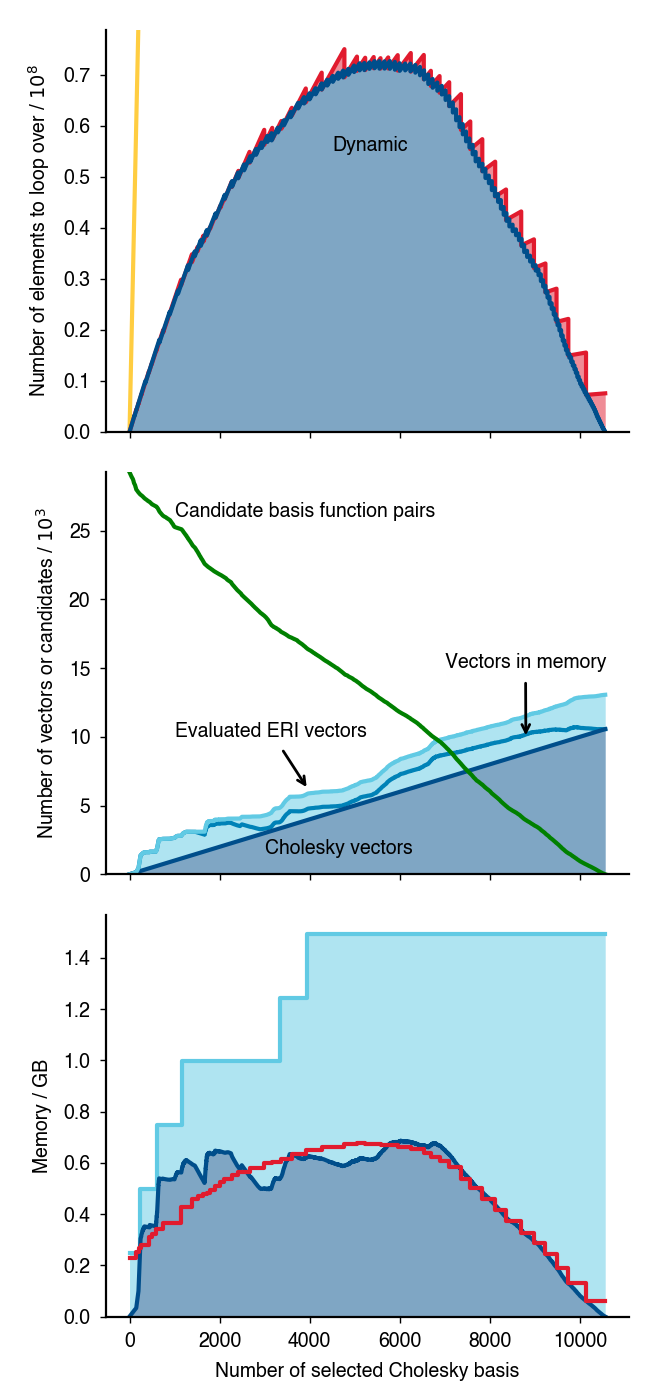

In [24]:
sys = 'W50'
tau = '1e-8'
steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes = parseDynamic(sys, tau)
sfsteps, sfmems, sfpivotMems = parseSpanFactor(sys, tau)
fig, ax = plt.subplots(3,1, sharex=True)

plotDetail(ax, 1e-8, 1e-3, 1e-9, steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, sfpivotMems)


ax[0].set_ylim([0, 1.05 / 8e8 * max(max(pivotMems),max(sfpivotMems))])
# ax[0].set_yticks([0, 0.5, 1, 1.5, 2])
ax[0].set_ylabel('Number of elements to loop over / $10^8$')
# ax[0].text(500, 1.8, 'Traditional')
# ax[0].text(3000, 1.6, 'Span-Factor')
# ax[0].text(400, 1.1, 'Traditional')
# ax[0].text(3000, 0.95, 'Span-Factor')
ax[0].text(4500, .55, 'Dynamic')

ax[1].set_ylim([0, nCands[0] * 10**-3])
ax[1].set_yticks([0, 5, 10, 15, 20, 25])
ax[1].set_ylabel('Number of vectors or candidates / $10^3$')
ax[1].text(1000, 26, 'Candidate basis function pairs')
# ax[1].text(1000, 7, 'Evaluated ERI vectors')
ax[1].annotate('Evaluated ERI vectors', xy = (4000,6), xytext = (1000, 10), arrowprops={'arrowstyle':'->'})
ax[1].annotate('Vectors in memory', xy = (8800,9.7), xytext = (7000, 15), arrowprops={'arrowstyle':'->'})
ax[1].text(3000, 1.5, 'Cholesky vectors')

ax[2].set_ylim([0, 1.05e-9 * max(max(sfmems),max(allocBlockSizes))])
# ax[2].set_yticks([0,0.5,1,1.5,2])
ax[2].set_ylabel('Memory / GB')
# ax[2].text(3800, 1.8, 'Allocated in span-factor algorithm')
# ax[2].text(1300, 0.9, 'Allocated in dynamic algorithm')
# ax[2].text(1500, .4, 'Necessary in dynamic algorithm')

ax[2].set_xlabel('Number of selected Cholesky basis')

plt.tight_layout()
plt.savefig('W50.pdf')

<IPython.core.display.Javascript object>


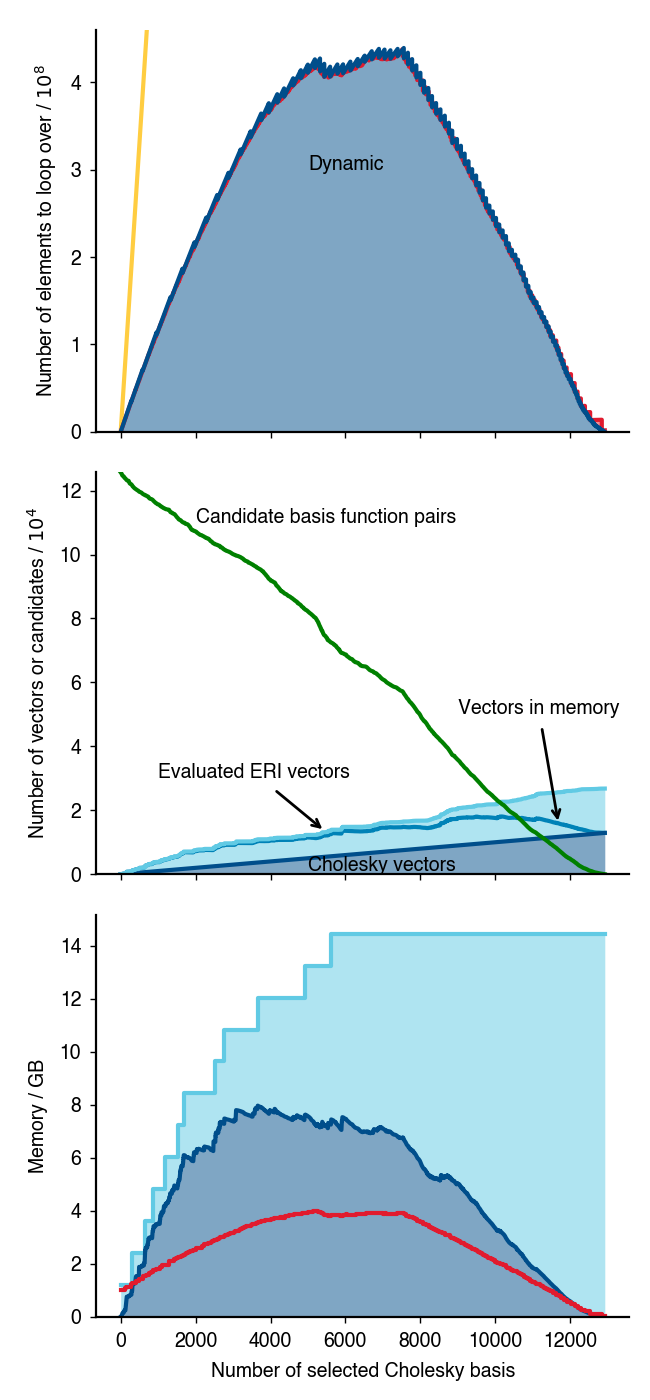

In [25]:
sys = 'Au14'
tau = '1e-8'
steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes = parseDynamic(sys, tau)
sfsteps, sfmems, sfpivotMems = parseSpanFactor(sys, tau)
fig, ax = plt.subplots(3,1, sharex=True)

plotDetail(ax, 1e-8, 1e-4, 1e-9, steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, sfpivotMems)


ax[0].set_ylim([0, 1.05 / 8e8 * max(max(pivotMems),max(sfpivotMems))])
# ax[0].set_yticks([0, 1, 2, 3, 4])
ax[0].set_ylabel('Number of elements to loop over / $10^8$')
# ax[0].text(700, 7, 'Traditional')
# ax[0].text(3800, 5, 'Span-Factor')
# ax[0].text(1100, 5.8, 'Traditional')
# ax[0].text(2000, 5, 'Span-Factor')
ax[0].text(5000, 3, 'Dynamic')

ax[1].set_ylim([0, nCands[0] * 10**-4])
ax[1].set_ylabel('Number of vectors or candidates / $10^4$')
ax[1].text(2000, 11, 'Candidate basis function pairs')
ax[1].annotate('Evaluated ERI vectors', xy = (5500,1.3), xytext = (1000, 3), arrowprops={'arrowstyle':'->'})
ax[1].annotate('Vectors in memory', xy = (11700,1.5), xytext = (9000, 5), arrowprops={'arrowstyle':'->'})
ax[1].text(5000, 0.1, 'Cholesky vectors')

ax[2].set_ylim([0, 1.05e-9 * max(max(sfmems),max(allocBlockSizes))])
ax[2].set_ylabel('Memory / GB')
# ax[2].set_yticks([0, 10, 20, 30])
# ax[2].text(500, 29, 'Allocated in span-factor algorithm')
# ax[2].text(900, 15, 'Allocated in dynamic algorithm')
# ax[2].text(1500, 3, 'Necessary in dynamic algorithm')


ax[2].set_xlabel('Number of selected Cholesky basis')

plt.tight_layout()
plt.savefig('Au14.pdf')



*************
 H1000 1e-4


<IPython.core.display.Javascript object>


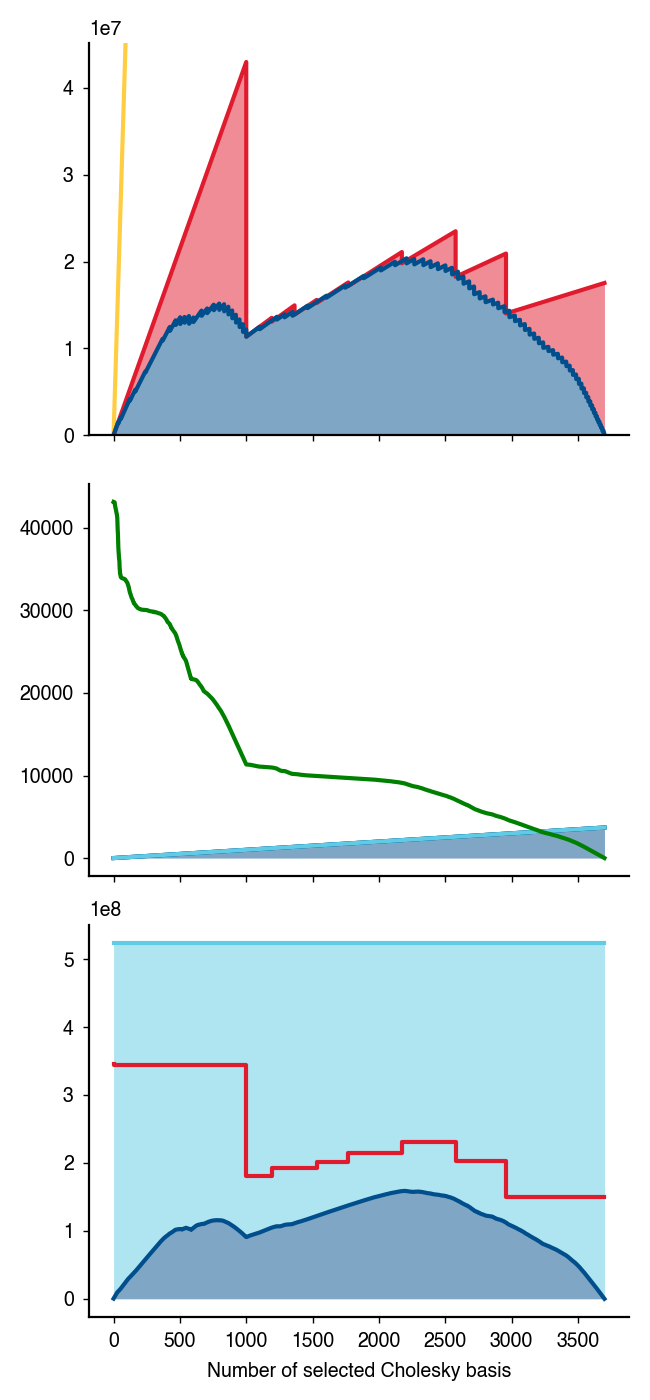

initial Cands: 43144
nPivotDynamic: 3700
   maxNmalloc: 3700
ERI vec useful ratio: 1.0
      maxNvec: 3700
       maxMem: 0.158828048
  maxAllocMem: 0.524288
    maxSFmems: 0.345152
 Dynamic cost: 391700948688
 Dy real cost: 398702652792
 Dy extra cost: 0.01756121775204922
      SF cost: 546366328376
    Trad cost: 27399972600000
SF Cost ratio: 1.3948557699593294
Tr Cost ratio: 69.95125411816348


*************
 H1000 1e-6


<IPython.core.display.Javascript object>


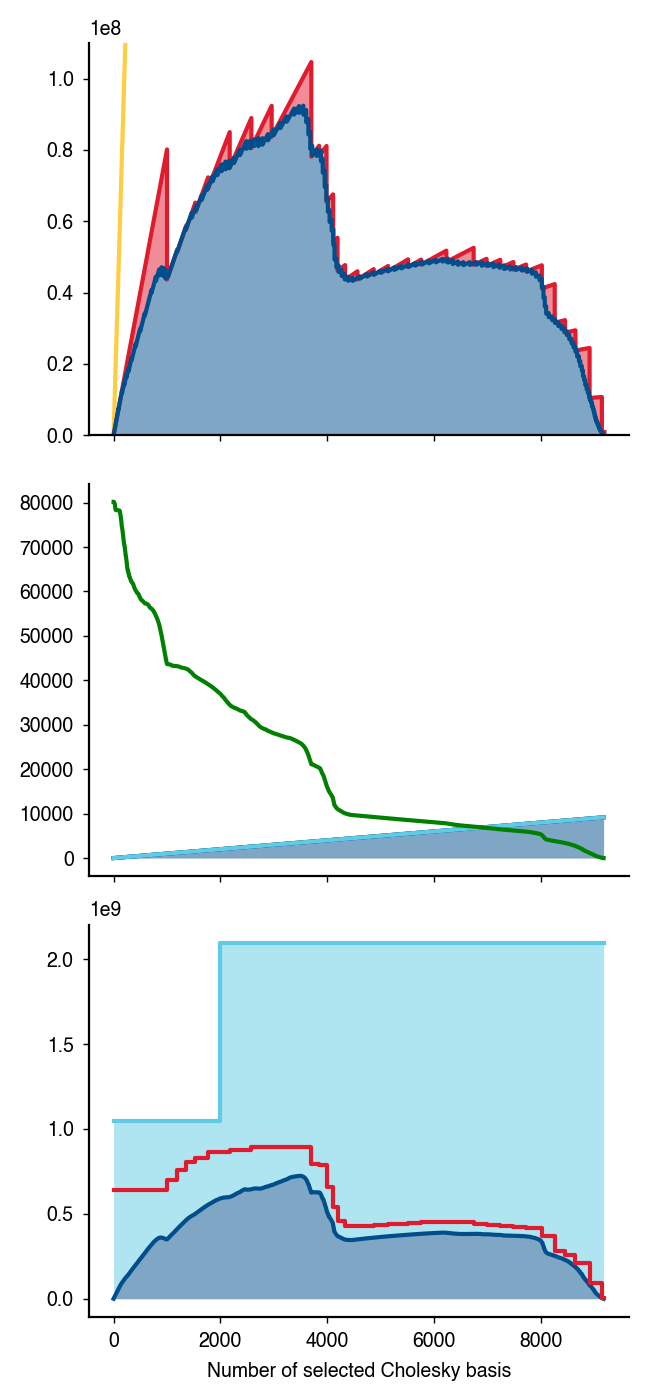

initial Cands: 80172
nPivotDynamic: 9168
   maxNmalloc: 9168
ERI vec useful ratio: 1.0
      maxNvec: 9168
       maxMem: 0.723786072
  maxAllocMem: 2.097152
    maxSFmems: 0.895742896
 Dynamic cost: 3718414109816
 Dy real cost: 3763910851232
 Dy extra cost: 0.012087624604899427
      SF cost: 4009910662804
    Trad cost: 168254198112000
SF Cost ratio: 1.0783927083910576
Tr Cost ratio: 45.24891341925491


*************
 H1000 1e-8


<IPython.core.display.Javascript object>


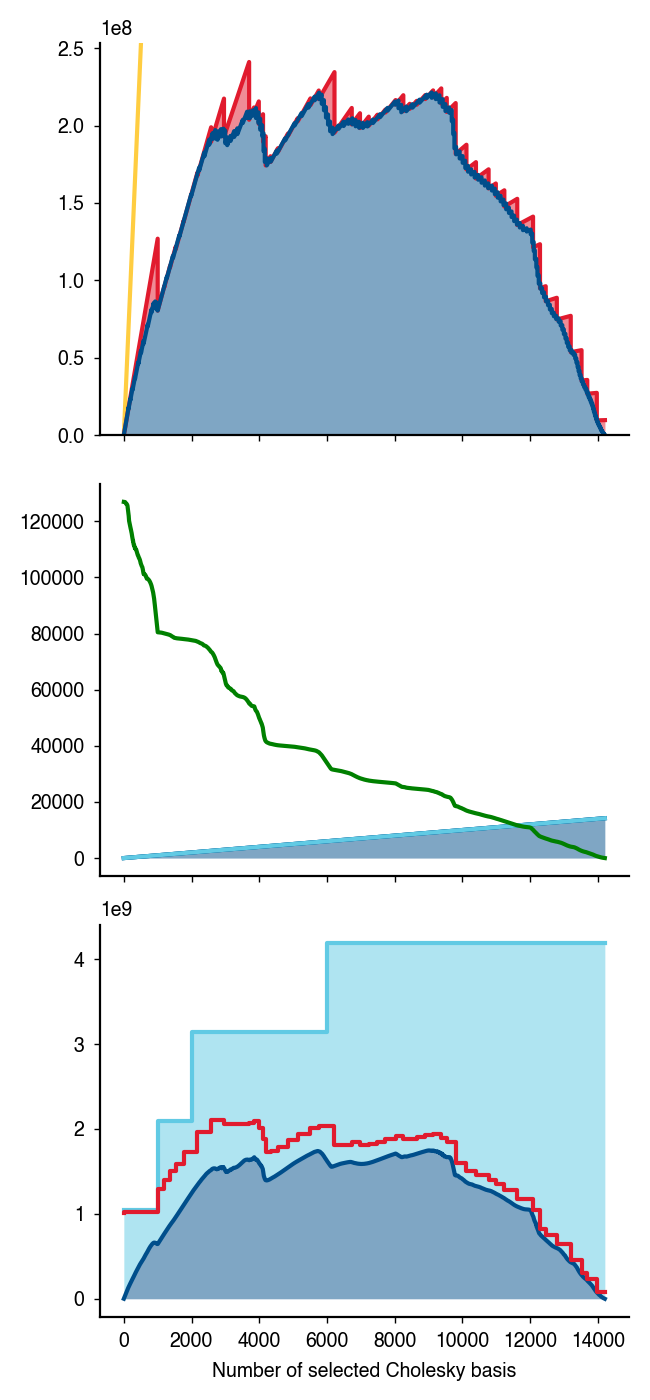

initial Cands: 126924
nPivotDynamic: 14205
   maxNmalloc: 14205
ERI vec useful ratio: 1.0
      maxNvec: 14205
       maxMem: 1.747418136
  maxAllocMem: 4.194304
    maxSFmems: 2.103921248
 Dynamic cost: 17565609208984
 Dy real cost: 17730277132408
 Dy extra cost: 0.00928738576358823
      SF cost: 18342655467824
    Trad cost: 403939175640000
SF Cost ratio: 1.0442367952967198
Tr Cost ratio: 22.996024267316827


*************
 C60vdz 1e-4


<IPython.core.display.Javascript object>


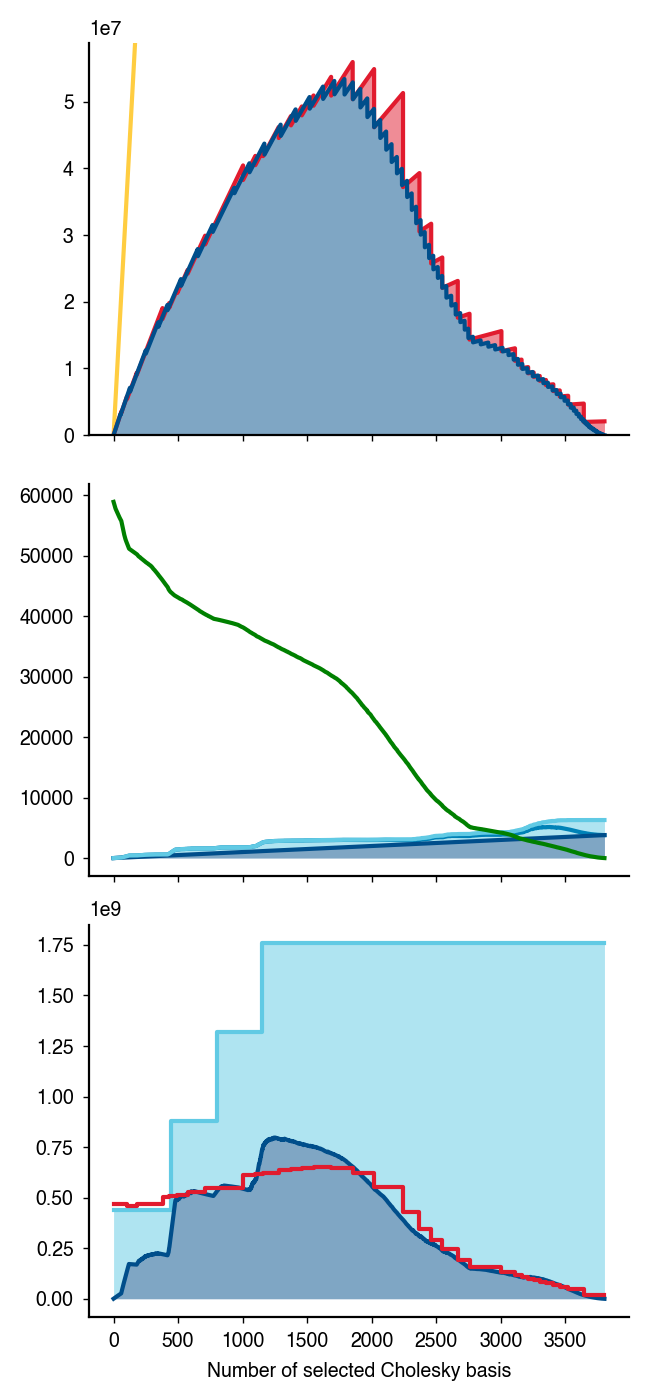

initial Cands: 58923
nPivotDynamic: 3802
   maxNmalloc: 6292
ERI vec useful ratio: 0.6042593769866497
      maxNvec: 5153
       maxMem: 0.79747416
  maxAllocMem: 1.76160768
    maxSFmems: 0.64942292
 Dynamic cost: 792337306448
 Dy real cost: 811595854120
 Dy extra cost: 0.02372923367490798
      SF cost: 843157823840
    Trad cost: 20418096857760
SF Cost ratio: 1.0641400032264356
Tr Cost ratio: 25.769450323238075


*************
 C60vdz 1e-6


<IPython.core.display.Javascript object>


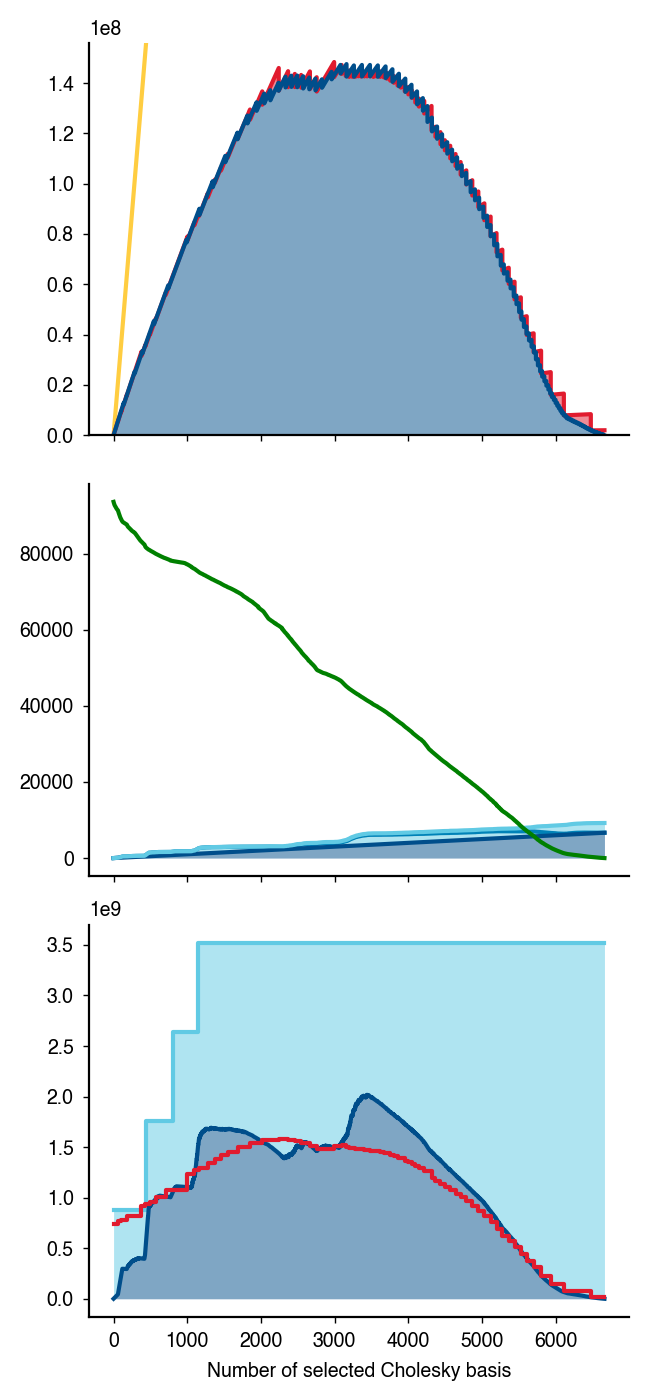

initial Cands: 93636
nPivotDynamic: 6663
   maxNmalloc: 9221
ERI vec useful ratio: 0.7225897408090228
      maxNvec: 7077
       maxMem: 2.01788336
  maxAllocMem: 3.52321536
    maxSFmems: 1.58098332
 Dynamic cost: 4723703539480
 Dy real cost: 4805195927088
 Dy extra cost: 0.016959222650757777
      SF cost: 4842011356300
    Trad cost: 62716197509280
SF Cost ratio: 1.0250455634717974
Tr Cost ratio: 13.27691227552862


*************
 C60vdz 1e-8


<IPython.core.display.Javascript object>


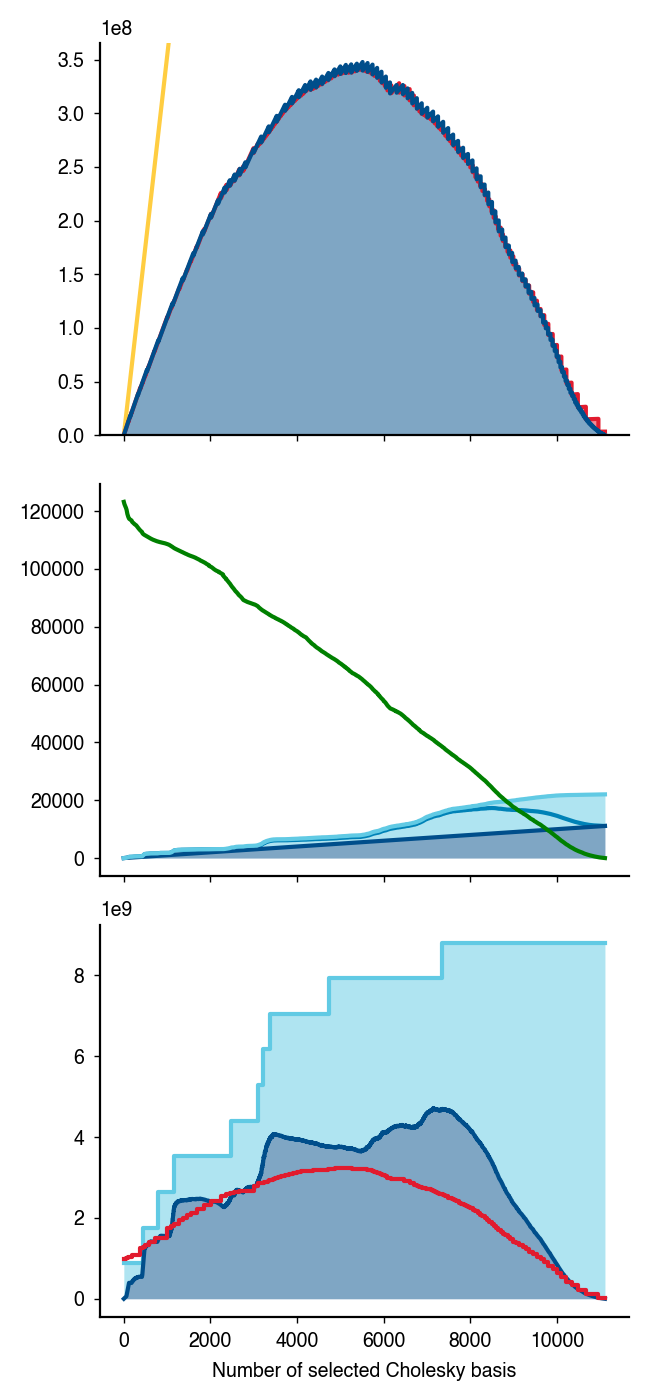

initial Cands: 123200
nPivotDynamic: 11108
   maxNmalloc: 22037
ERI vec useful ratio: 0.5040613513636157
      maxNvec: 17331
       maxMem: 4.709472144
  maxAllocMem: 8.8080384
    maxSFmems: 3.229962336
 Dynamic cost: 18718029587408
 Dy real cost: 18980662620056
 Dy extra cost: 0.013836873764906832
      SF cost: 18943825988968
    Trad cost: 174316268441280
SF Cost ratio: 1.0120630433083564
Tr Cost ratio: 9.312746709116546


*************
 W50 1e-4


<IPython.core.display.Javascript object>


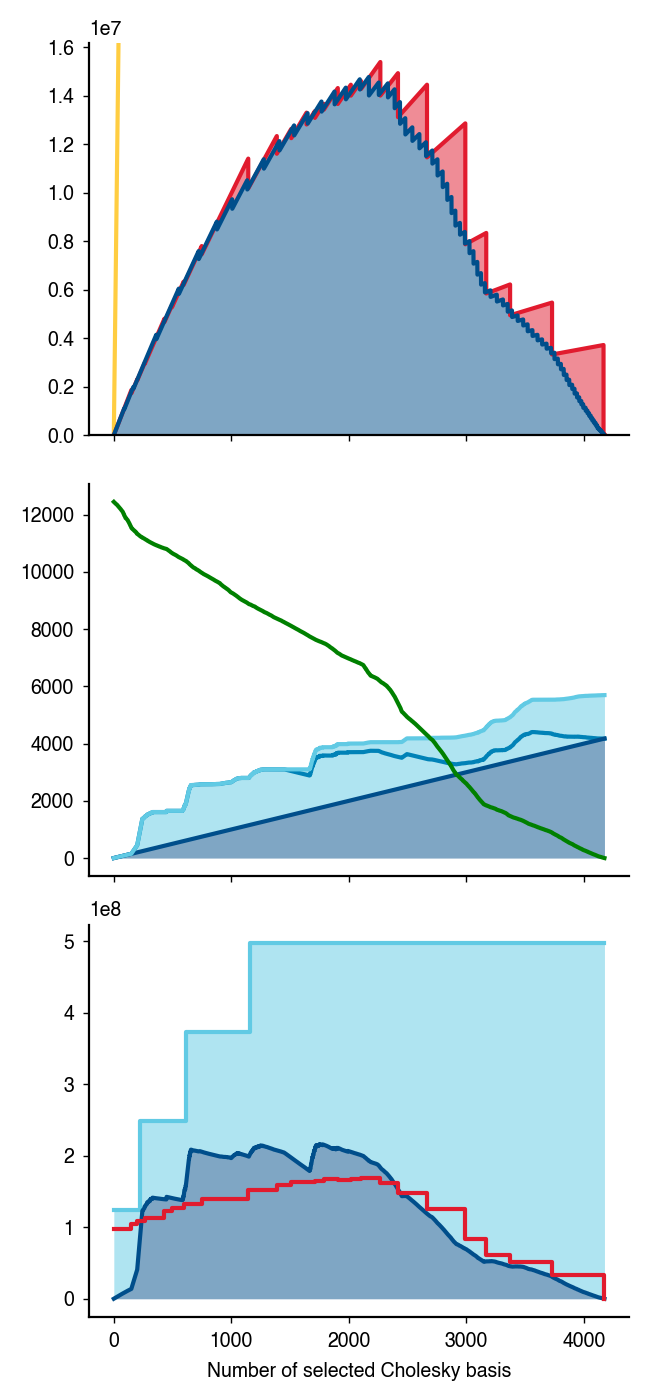

initial Cands: 12446
nPivotDynamic: 4175
   maxNmalloc: 5694
ERI vec useful ratio: 0.7332279592553566
      maxNvec: 4406
       maxMem: 0.216295128
  maxAllocMem: 0.4980736
    maxSFmems: 0.168351744
 Dynamic cost: 268774172160
 Dy real cost: 274842293880
 Dy extra cost: 0.022078558704830997
      SF cost: 296650036068
    Trad cost: 28262216610000
SF Cost ratio: 1.1037148163604262
Tr Cost ratio: 105.15227852018324


*************
 W50 1e-6


<IPython.core.display.Javascript object>


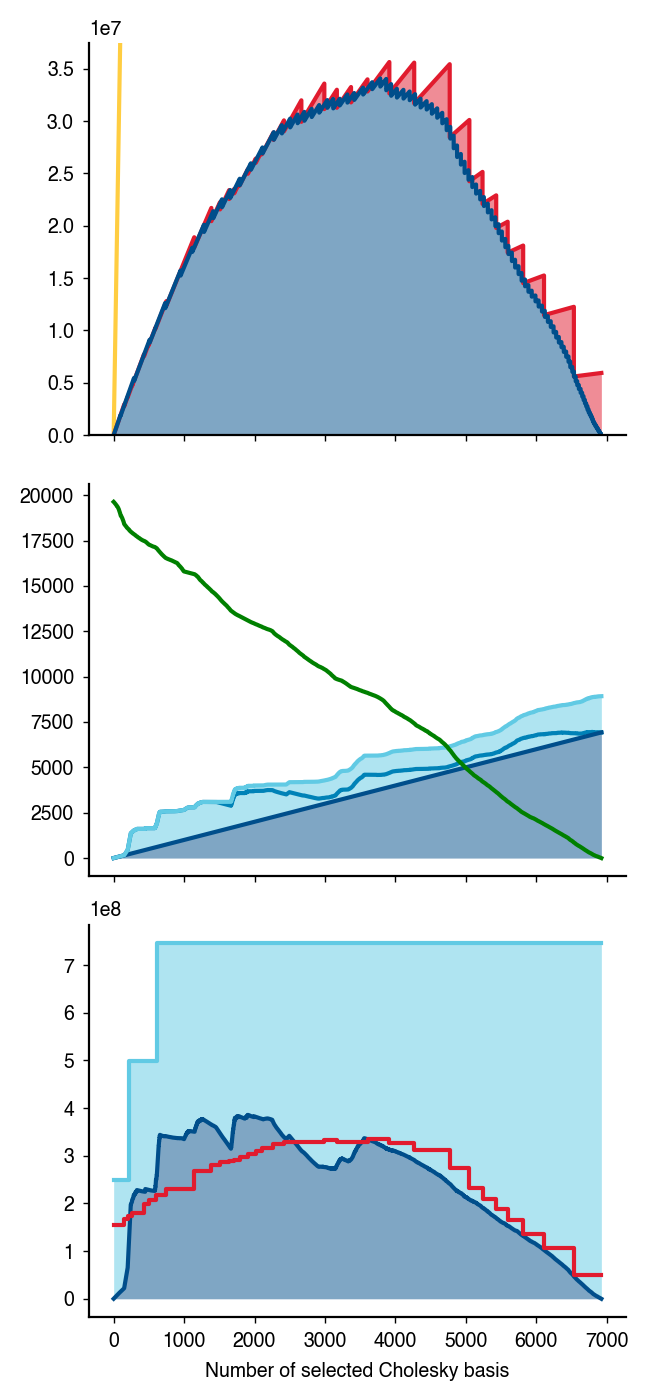

initial Cands: 19630
nPivotDynamic: 6924
   maxNmalloc: 8921
ERI vec useful ratio: 0.7761461719538169
      maxNvec: 6952
       maxMem: 0.385772152
  maxAllocMem: 0.7471104
    maxSFmems: 0.33535536
 Dynamic cost: 1165637877760
 Dy real cost: 1183643857288
 Dy extra cost: 0.015212328790566998
      SF cost: 1242132822316
    Trad cost: 77740742973600
SF Cost ratio: 1.0656249646785672
Tr Cost ratio: 66.69373435512748


*************
 W50 1e-8


<IPython.core.display.Javascript object>


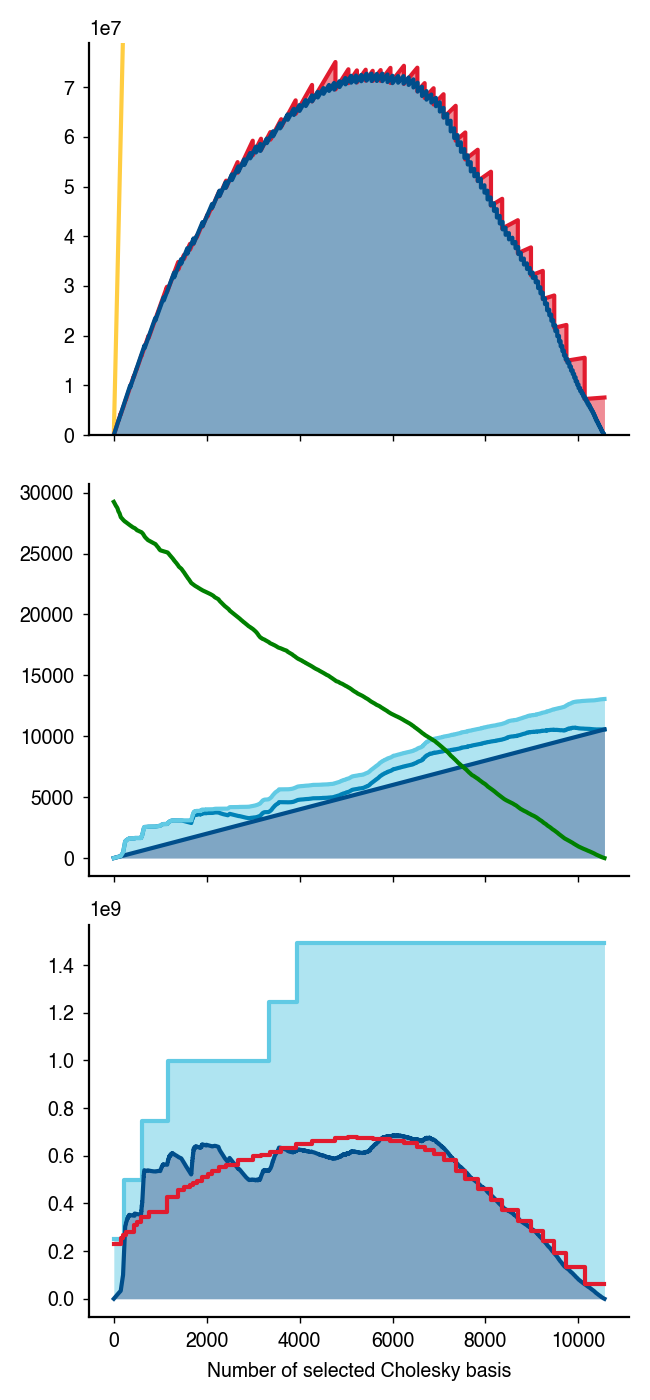

initial Cands: 29245
nPivotDynamic: 10562
   maxNmalloc: 13060
ERI vec useful ratio: 0.808728943338438
      maxNvec: 10710
       maxMem: 0.686507264
  maxAllocMem: 1.4942208
    maxSFmems: 0.678310664
 Dynamic cost: 3903423720632
 Dy real cost: 3951928185616
 Dy extra cost: 0.01227362004212118
      SF cost: 4060824321828
    Trad cost: 180904138347600
SF Cost ratio: 1.0403237292339136
Tr Cost ratio: 46.34499129351757


*************
 Au14 1e-4


<IPython.core.display.Javascript object>


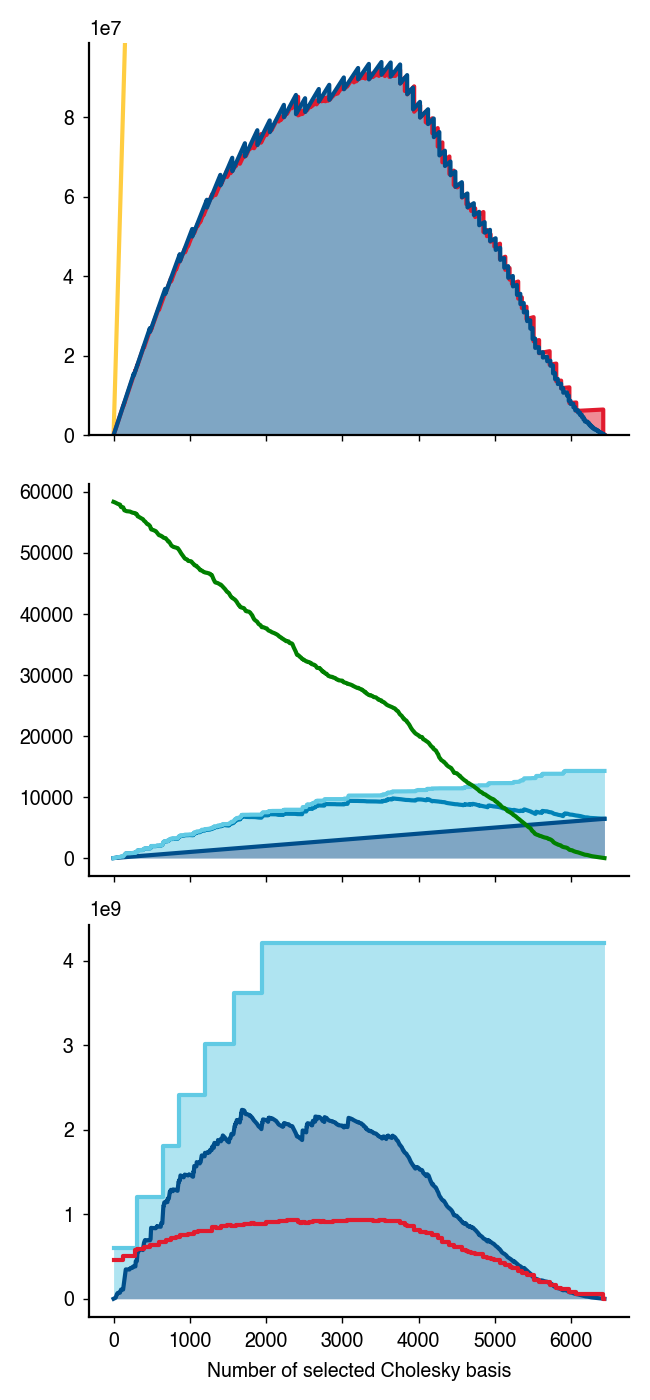

initial Cands: 58377
nPivotDynamic: 6436
   maxNmalloc: 14279
ERI vec useful ratio: 0.4507318439666643
      maxNvec: 9770
       maxMem: 2.234762
  maxAllocMem: 4.213178368
    maxSFmems: 0.935690448
 Dynamic cost: 2806501883352
 Dy real cost: 2871946615128
 Dy extra cost: 0.022787586451387898
      SF cost: 2861120953832
    Trad cost: 109258818308640
SF Cost ratio: 1.0194616190368504
Tr Cost ratio: 38.93060573262278


*************
 Au14 1e-6


<IPython.core.display.Javascript object>


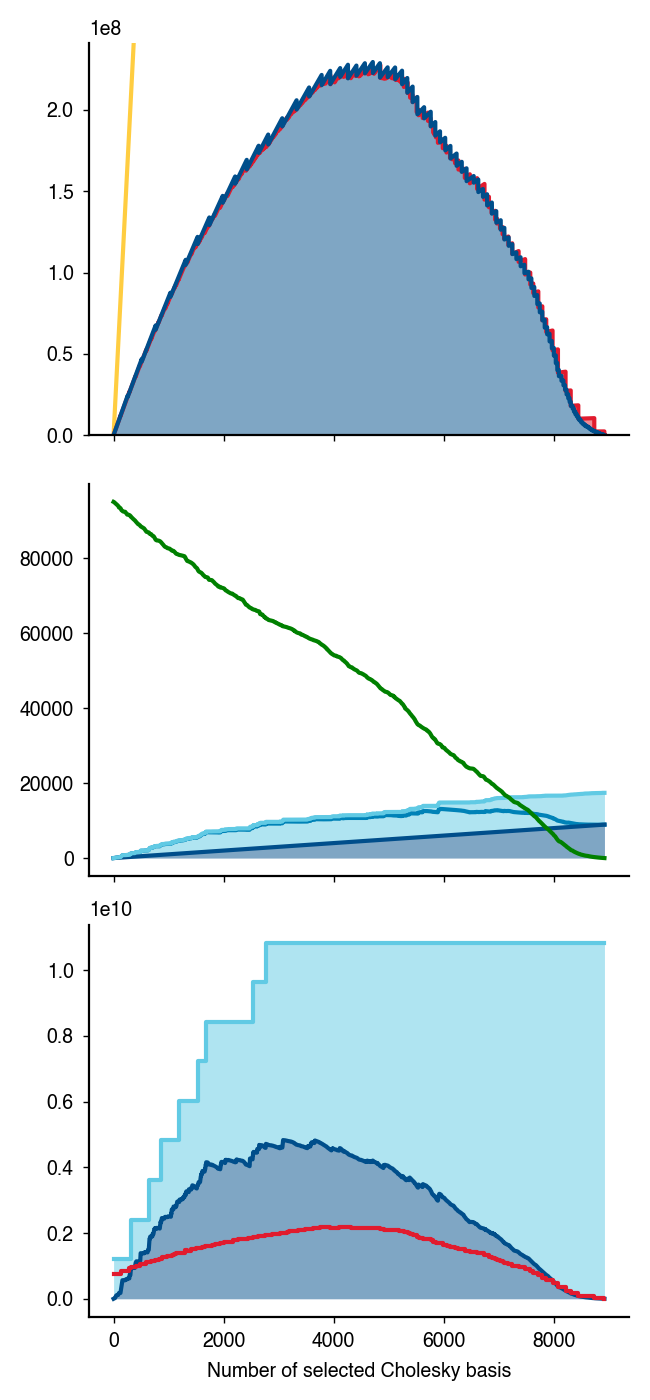

initial Cands: 95009
nPivotDynamic: 8920
   maxNmalloc: 17403
ERI vec useful ratio: 0.5125553065563409
      maxNvec: 13107
       maxMem: 4.8287798
  maxAllocMem: 10.833887232
    maxSFmems: 2.1886956
 Dynamic cost: 9707358802520
 Dy real cost: 9884404670712
 Dy extra cost: 0.01791163697664022
      SF cost: 9837785760924
    Trad cost: 209880906217920
SF Cost ratio: 1.0134358851936267
Tr Cost ratio: 21.620804431730242


*************
 Au14 1e-8


<IPython.core.display.Javascript object>


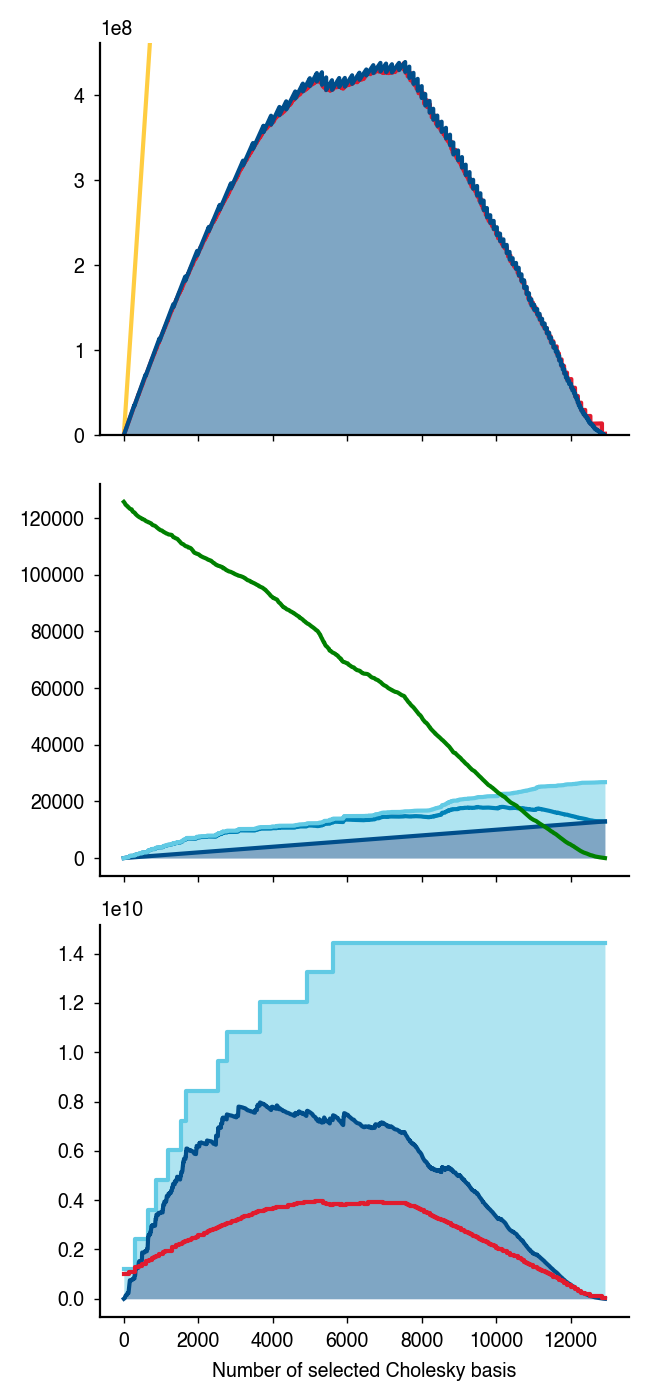

initial Cands: 125694
nPivotDynamic: 12925
   maxNmalloc: 26793
ERI vec useful ratio: 0.4824021199567051
      maxNvec: 18070
       maxMem: 7.962664864
  maxAllocMem: 14.445182976
    maxSFmems: 3.969471712
 Dynamic cost: 27410238978672
 Dy real cost: 27806163060816
 Dy extra cost: 0.014238716836913357
      SF cost: 27618147650944
    Trad cost: 440676015040800
SF Cost ratio: 1.0075850733163536
Tr Cost ratio: 16.077058481091374


In [19]:
for sys in syss:
    curTaus = taus
#     if sys == 'Au14':
#         curTaus = taus_Au
    for tau in curTaus:
        print('\n\n*************\n', sys, tau)
#         steps, nMallocs, nVecs, nCands, mems, pivotMems, allocBlockSteps, allocBlockSizes = parseDynamic(sys, tau)
#         sfsteps, sfmems, sfpivotMems = parseSpanFactor(sys, tau)
# #         plotMem(steps, mems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems)
# #         plotCost(nBases[sys], steps, pivotMems, sfsteps, sfpivotMems)
# #         plotNumber(steps, nMallocs, nVecs, nCands)
#         plotSubs(steps, mems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, nMallocs, nVecs, nCands, pivotMems, sfpivotMems, nBases[sys])
        steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes = parseDynamic(sys, tau)
        sfsteps, sfmems, sfpivotMems = parseSpanFactor(sys, tau)
        fig, ax = plt.subplots(3,1, sharex=True)

        plotDetail(ax, 1, 1, 1, steps, nMallocs, nVecs, nCands, nLenVecs, mems, pivotMems, allocBlockSteps, allocBlockSizes, sfsteps, sfmems, sfpivotMems)
        plt.tight_layout()

        print('initial Cands:', nCands[0])
        print('nPivotDynamic:', nVecs[-1])
        print('   maxNmalloc:', nMallocs[-1])
        print('ERI vec useful ratio:', nVecs[-1]/nMallocs[-1])
        print('      maxNvec:', max(nVecs))
        print('       maxMem:', max(mems)/1000**3)
        print('  maxAllocMem:', max(allocBlockSizes)/1000**3)
        print('    maxSFmems:', max(sfmems)/1000**3)
        dyCost = curveIntegral(steps, pivotMems)
        dyCostActual = curveIntegral(steps, [i * nLenVecs[i] * 8 for i in range(len(steps))])
        sfCost = curveIntegral(sfsteps, sfpivotMems)
        tradCost = steps[-1]*(steps[-1]-1)//2 * nBases[sys]*(nBases[sys] + 1)//2 * 8
        print(' Dynamic cost:', dyCost)
        print(' Dy real cost:', dyCostActual)
        print(' Dy extra cost:', 1 - dyCost / dyCostActual)
        print('      SF cost:', sfCost)
        print('    Trad cost:', tradCost)
        print('SF Cost ratio:', sfCost / dyCost)
        print('Tr Cost ratio:', tradCost / dyCost)